In [1]:
from flipper import liteMap
import matplotlib.pyplot as plt
import numpy as np
from cactusLib import filterLib
from cactusLib.cactusUtils import saveFits
from flipper import fftTools
import scipy


/home/cvargas/.local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
#Marsden Area

RA0 = 3.
RA1 = 106.75
DEC0 = -56.2
DEC1 = -49.0


lt = liteMap.liteMapFromFits("/home/cvargas/data/act/act_depots/cactus_depots/20180419/ACT_220_south_season_2_1way_v3_srcfree.fits")

ltw = liteMap.liteMapFromFits("/home/cvargas/data/act/act_depots/cactus_depots/20180419/ACT_220_south_season_2_1way_hits_v3.fits")

lt = lt.selectSubMap(RA0,RA1,DEC0,DEC1)
ltw = ltw.selectSubMap(RA0,RA1,DEC0,DEC1)

lt.data = lt.data*np.sqrt(ltw.data)

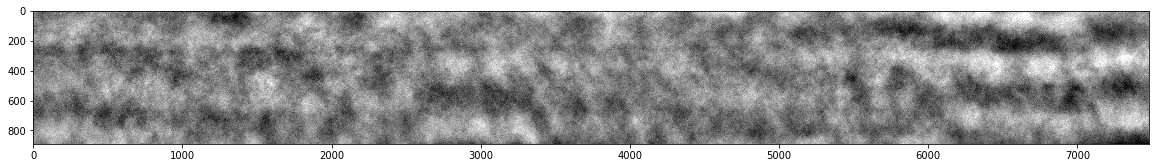

In [3]:
plt.figure(figsize=(20,15))
plt.imshow(lt.data,cmap="gray",vmin = -3e5, vmax= 3e5)
plt.show()

saveFits(lt.data/np.sqrt(ltw.data),"Original_noise.fits",lt.header)

In [4]:
lt_std = np.std(lt.data)
lt_std

88121.19930551681

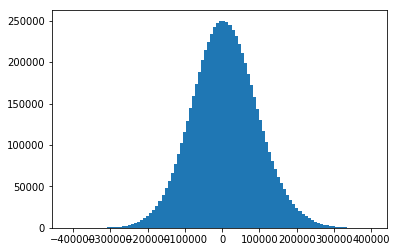

In [5]:
plt.hist(lt.data.flatten(),100)
plt.show()

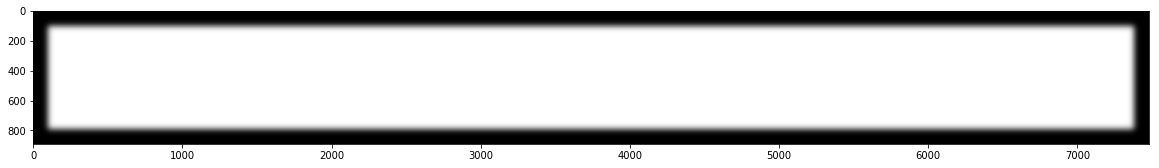

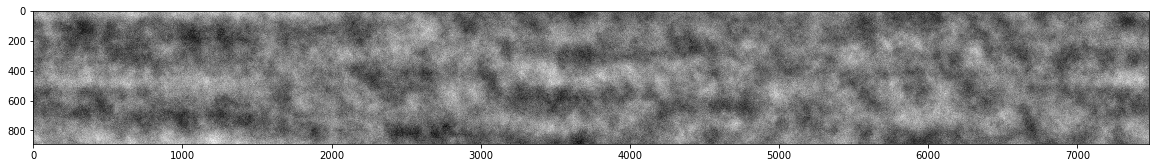

1.2086039201349073
1.2086039201349077
1.2051562385385137


In [6]:
#Example of one new random realization

mu = 0.
sigma = 1.
Ny,Nx = lt.data.shape
new = np.fft.fft2(np.random.normal(mu,sigma,(Ny,Nx)))
new_exp = new/np.abs(new)


#We need the apodize the map before taking the FFT ###############
#or the spectrum will be too noise

noiseMap = lt.copy()

pad = 100
extraYPad = 0
apodNy,apodNx = noiseMap.data.shape
apod = noiseMap.data.copy()
apod[:] = 0.0
apod[pad+extraYPad:apodNy-pad-extraYPad,pad:apodNx-pad] = 1.0
N_apod = scipy.ndimage.gaussian_filter(apod,20,mode="constant")

plt.figure(figsize=(20,15))
plt.imshow(N_apod,cmap="gray")
plt.show()

noiseMap.data *= N_apod

FTNM = fftTools.fftFromLiteMap(noiseMap)

a = np.abs(FTNM.kMap)

##################################################################
M_fft2 = a*new_exp
M_fft2 = filterLib.symmetrizeFFT(M_fft2)
M = np.real(np.fft.ifft2(M_fft2))


plt.figure(figsize=(20,15))
plt.imshow(M,cmap="gray")
plt.show()

M_std = np.std(M)

f = lt_std/M_std

#Since we applied an apodization we need to find a normalization
#we can do that bia Parseval/Plancheret real of fft space gives
#the same answer

print np.sqrt(np.sum(lt.data**2)/np.sum(noiseMap.data**2))

print np.sqrt(np.sum(np.abs(np.fft.fft2(lt.data))**2)/np.sum(np.abs(np.fft.fft2(noiseMap.data))**2))

print f
#M*= f
    

In [7]:
def new_realization(lt,i): 
    #Getting new exponential from a random realization
    mu = 0.
    sigma = 1.
    Ny,Nx = lt.data.shape
    new = np.fft.fft2(np.random.normal(mu,sigma,(Ny,Nx)))
    new_exp = new/np.abs(new)
    #New fft
    #M_fft2 = a*new_exp
    #real part of ifft
    #M = np.real(np.fft.ifft2(M_fft2))
    
    #Making the power spectrum a bit softer #############################
    
    noiseMap = lt.copy()

    pad = 100
    extraYPad = 0
    apodNy,apodNx = noiseMap.data.shape
    apod = noiseMap.data.copy()
    apod[:] = 0.0
    apod[pad+extraYPad:apodNy-pad-extraYPad,pad:apodNx-pad] = 1.0
    N_apod = scipy.ndimage.gaussian_filter(apod,20,mode="constant")
    
    noiseMap.data *= N_apod
    
    FTNM = fftTools.fftFromLiteMap(noiseMap)
    
    a = np.abs(FTNM.kMap)
    
    M_fft2 = a*new_exp
    M_fft2 = filterLib.symmetrizeFFT(M_fft2)
    M = np.real(np.fft.ifft2(M_fft2))
    
    plt.figure(figsize=(20,15))
    plt.imshow(M,cmap="gray")
    
    f = np.sqrt(np.sum(lt.data**2)/np.sum(noiseMap.data**2))
    
    M*= f
    
    saveFits(M/np.sqrt(ltw.data),"noise{}.fits".format(i),lt.header)

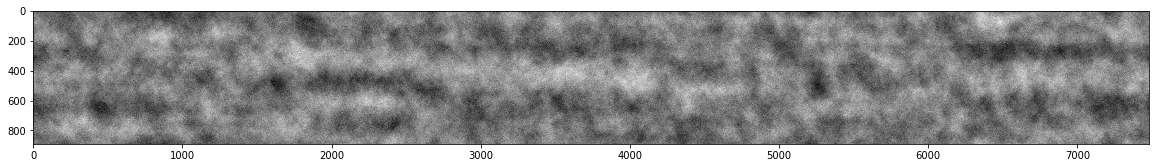

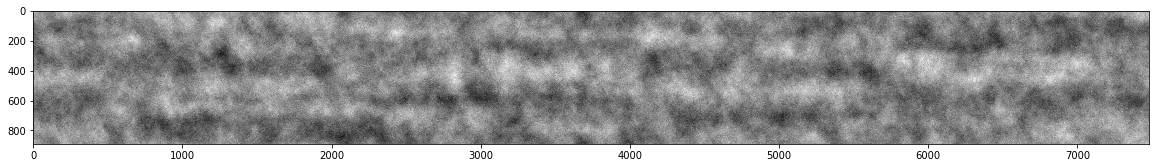

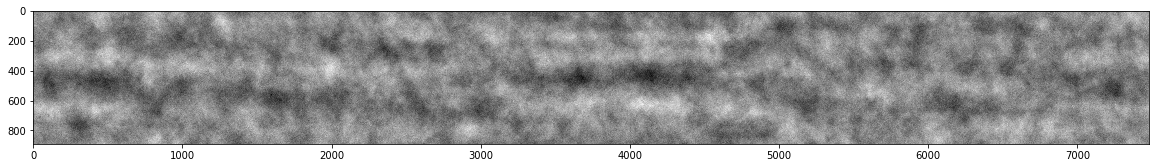

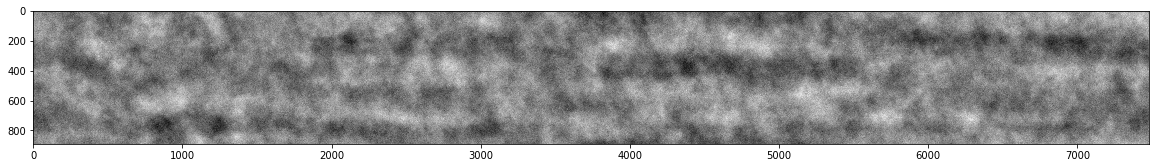

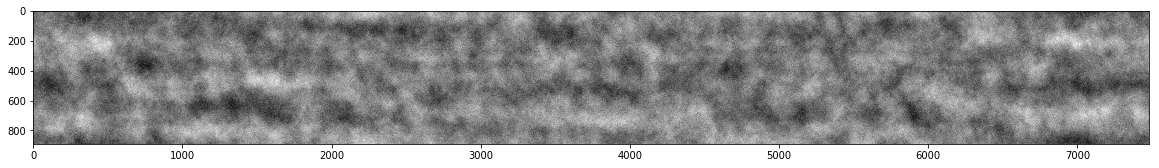

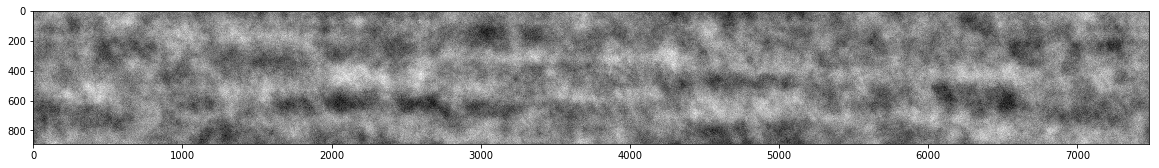

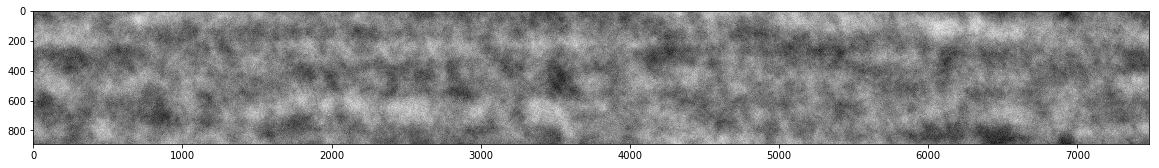

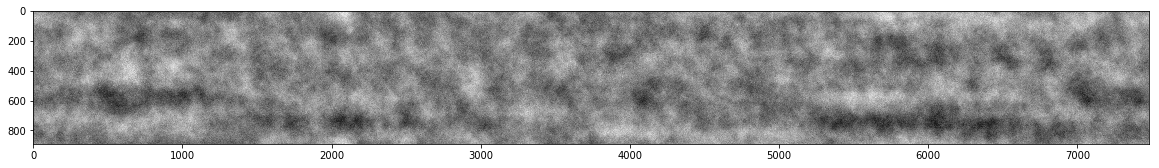

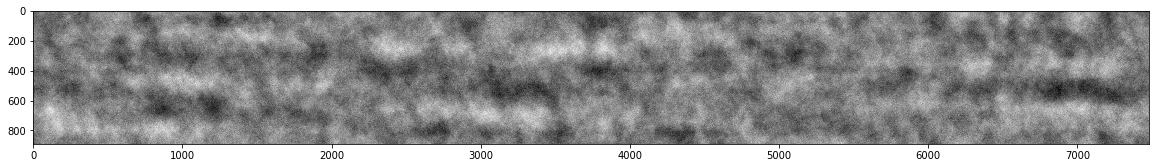

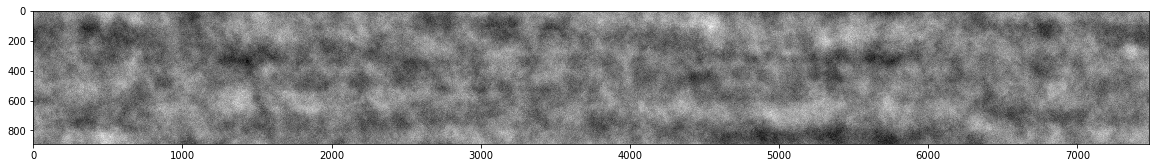

In [8]:
for i in range(10):
    new_realization(lt,i)